# Importing Packages

In [15]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Metrics
from sklearn.metrics import mean_squared_error

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Bayes Optimization
import optuna
from functools import partial

# Saving Models
import joblib

# Helper Functions

In [2]:
def optimize(trial, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray):
    """
    Function used to produce optimized (Bayesian Optimization) Random Forests regressor
    
    INPUTS:
        :trial: One Optimization trial.
        :X_train (np.ndarray): Training data
        :y_train (np.ndarray): Training labels
        :X_test (np.ndarray): Testing data
        :y_test (np.ndarray): Testing labels
    """
    # Define Parameter Space
    criterion = trial.suggest_categorical("criterion", ["absolute_error", "squared_error", "poisson"])
    n_estimators = trial.suggest_int("n_estimators", 100, 1500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    max_features = trial.suggest_uniform("max_features", 0.01, 1.0)
    max_samples = trial.suggest_uniform("max_samples", 0.01, 1.0)

    # Define Model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        criterion=criterion,
        max_samples=max_samples,
        random_state=42
    )
    
    # Fit model
    model.fit(X_train, y_train)
    # Predictions and MSE
    preds = model.predict(X_test)
    mse = mean_squared_error(y_true=y_test, y_pred=preds)

    # Return MSE
    return mse

In [3]:
def fit_rf_model(df: pd.DataFrame, company_name: str):
    """
    Fitting an Optimized Random Forests Model for each Company
    
    INPUTS:
        :df (pd.DataFrame): Input dataframe
        :company_name (str): Company name
    """
    # Train test split
    train = df.loc[:"2021-10-29", :]
    test = df.loc["2021-10-29":, :]
    # Splitting into targets and features
    X_train, y_train = train.drop(["Adj_Close"], axis=1).to_numpy(), train["Adj_Close"].to_numpy()
    X_test, y_test = test.drop(["Adj_Close"], axis=1).to_numpy(), test["Adj_Close"].to_numpy()
    
    # Bayesian Optimization using Optuna
    optimization_function = partial(optimize, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    study = optuna.create_study(direction="minimize")
    study.optimize(optimization_function, n_trials=15)
    
    # Fitting the best model
    model = RandomForestRegressor(**study.best_params, random_state=42)
    model.fit(X_train, y_train)

    # Train and Test Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Train and Test performance (MSE and RMSE)
    train_mse = mean_squared_error(y_true=y_train, y_pred=train_preds)
    test_mse = mean_squared_error(y_true=y_train, y_pred=train_preds)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    print(f"Training RMSE: {round(train_rmse, 4)}")
    print(f"Testing RMSE: {round(test_rmse, 4)}")
    print("-"*30, end="\n\n")


    # Plotting train and test predictions vs actual values
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(y_train, label="Train values")
    ax[0].plot(train_preds, label="Train predictions")
    ax[0].set_xlabel("Time", size=12)
    ax[0].set_ylabel("Stock Price", size=12)
    ax[0].set_ylim([y_train.min()-10, y_train.max()+10])
    ax[0].set_title(f"{company_name}: Train values vs predictions", size=15)
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(y_test, label="Test values")
    ax[1].plot(test_preds, label="Test predictions")
    ax[1].set_xlabel("Time", size=12)
    ax[1].set_ylabel("Stock Price", size=12)
    ax[1].set_ylim([y_train.min()-10, y_test.max()+10])
    ax[1].set_title(f"{company_name}: Test values vs predictions", size=15)
    ax[1].grid()
    ax[1].legend()

    plt.show()
    
    # Returning Model
    return model

# Fitting models for each company

## Facebook

Reading dataset, and adding past 10 days observations.

In [4]:
df = pd.read_csv("../Data/fb_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-07 22:25:37,279] A new study created in memory with name: no-name-a23351bf-5f3c-49c3-86d5-e5a2736be294
[I 2021-12-07 22:26:24,718] Trial 0 finished with value: 62.77727840747436 and parameters: {'criterion': 'absolute_error', 'n_estimators': 1037, 'max_depth': 13, 'max_features': 0.38204275855770625, 'max_samples': 0.8445114374533155}. Best is trial 0 with value: 62.77727840747436.
[I 2021-12-07 22:26:26,079] Trial 1 finished with value: 24574.13184232812 and parameters: {'criterion': 'poisson', 'n_estimators': 954, 'max_depth': 4, 'max_features': 0.3317526970662841, 'max_samples': 0.4582232117320536}. Best is trial 0 with value: 62.77727840747436.
[I 2021-12-07 22:26:26,454] Trial 2 finished with value: 25518.456140197333 and parameters: {'criterion': 'poisson', 'n_estimators': 309, 'max_depth': 4, 'max_features': 0.4211711195113877, 'max_samples': 0.2522943672194134}. Best is trial 0 with value: 62.77727840747436.
[I 2021-12-07 22:26:27,093] Trial 3 finished with value: 24

Training RMSE: 3.8258
Testing RMSE: 3.8258
------------------------------



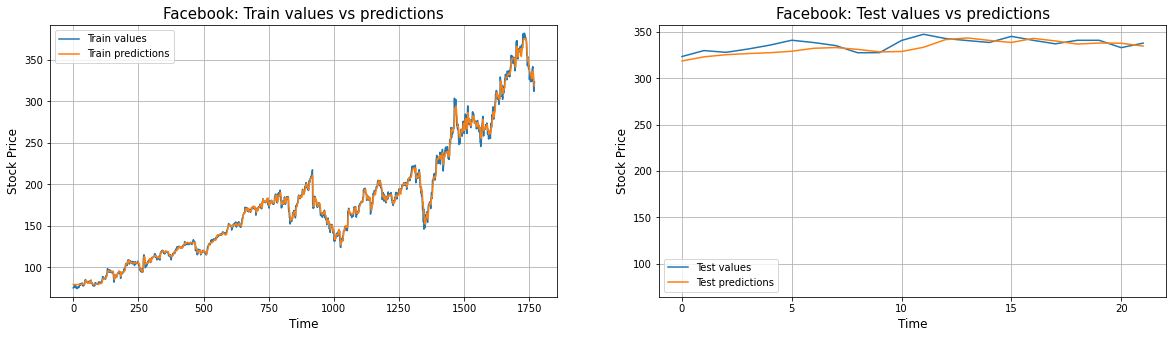

In [5]:
fb_model = fit_rf_model(df = df, company_name = "Facebook")

## Apple

Reading dataset, and adding past 10 days observations.

In [6]:
df = pd.read_csv("../Data/aapl_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-07 22:27:12,629] A new study created in memory with name: no-name-f55ac49d-d2ed-4714-bda2-50b23b1ff94a
[I 2021-12-07 22:27:18,568] Trial 0 finished with value: 26012.90006371228 and parameters: {'criterion': 'poisson', 'n_estimators': 1260, 'max_depth': 8, 'max_features': 0.4985862098559495, 'max_samples': 0.8940121716740808}. Best is trial 0 with value: 26012.90006371228.
[I 2021-12-07 22:27:23,721] Trial 1 finished with value: 25589.918162896767 and parameters: {'criterion': 'poisson', 'n_estimators': 1458, 'max_depth': 4, 'max_features': 0.9703921109607011, 'max_samples': 0.514552659167439}. Best is trial 1 with value: 25589.918162896767.
[I 2021-12-07 22:27:37,297] Trial 2 finished with value: 48.0966329800909 and parameters: {'criterion': 'absolute_error', 'n_estimators': 336, 'max_depth': 7, 'max_features': 0.4583622630927016, 'max_samples': 0.6977331190422866}. Best is trial 2 with value: 48.0966329800909.
[I 2021-12-07 22:27:38,394] Trial 3 finished with value: 101.2

Training RMSE: 2.6449
Testing RMSE: 2.6449
------------------------------



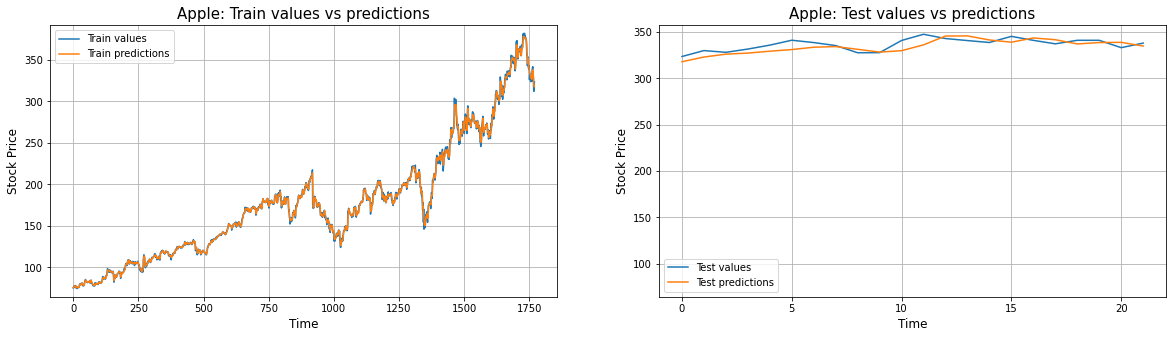

In [7]:
aapl_model = fit_rf_model(df = df, company_name = "Apple")

## Amazon

Reading dataset, and adding past 10 days observations.

In [8]:
df = pd.read_csv("../Data/amzn_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-07 22:30:12,165] A new study created in memory with name: no-name-90f8375c-bf99-489b-89f1-9b1f17fc8875
[I 2021-12-07 22:30:15,195] Trial 0 finished with value: 26377.010632611753 and parameters: {'criterion': 'poisson', 'n_estimators': 333, 'max_depth': 11, 'max_features': 0.77962962810503, 'max_samples': 0.7625470043870006}. Best is trial 0 with value: 26377.010632611753.
[I 2021-12-07 22:30:17,600] Trial 1 finished with value: 29.266657460121905 and parameters: {'criterion': 'squared_error', 'n_estimators': 996, 'max_depth': 8, 'max_features': 0.5472705445585484, 'max_samples': 0.42736992783586036}. Best is trial 1 with value: 29.266657460121905.
[I 2021-12-07 22:30:33,166] Trial 2 finished with value: 31.09490107823192 and parameters: {'criterion': 'absolute_error', 'n_estimators': 433, 'max_depth': 7, 'max_features': 0.307813869506064, 'max_samples': 0.8272283819690357}. Best is trial 1 with value: 29.266657460121905.
[I 2021-12-07 22:30:34,508] Trial 3 finished with val

Training RMSE: 3.7247
Testing RMSE: 3.7247
------------------------------



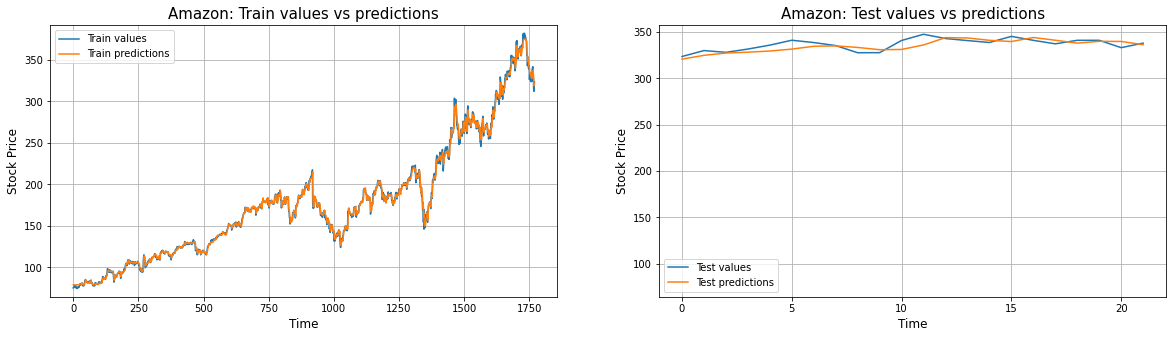

In [9]:
amzn_model = fit_rf_model(df = df, company_name = "Amazon")

## Netflix

Reading dataset, and adding past 10 days observations.

In [10]:
df = pd.read_csv("../Data/nflx_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-07 22:31:03,320] A new study created in memory with name: no-name-4cfb2ec8-b9f5-4c67-8b24-8fa8e8bdb8ed
[I 2021-12-07 22:31:36,745] Trial 0 finished with value: 42.91033763681575 and parameters: {'criterion': 'absolute_error', 'n_estimators': 794, 'max_depth': 15, 'max_features': 0.33068875376231227, 'max_samples': 0.8207531526747821}. Best is trial 0 with value: 42.91033763681575.
[I 2021-12-07 22:32:29,650] Trial 1 finished with value: 34.190404389008194 and parameters: {'criterion': 'absolute_error', 'n_estimators': 1195, 'max_depth': 12, 'max_features': 0.66166662405824, 'max_samples': 0.46999762009386215}. Best is trial 1 with value: 34.190404389008194.
[I 2021-12-07 22:32:32,319] Trial 2 finished with value: 37.2878937275261 and parameters: {'criterion': 'absolute_error', 'n_estimators': 179, 'max_depth': 9, 'max_features': 0.42532778031595614, 'max_samples': 0.27665476449662296}. Best is trial 1 with value: 34.190404389008194.
[I 2021-12-07 22:32:33,220] Trial 3 finish

Training RMSE: 3.538
Testing RMSE: 3.538
------------------------------



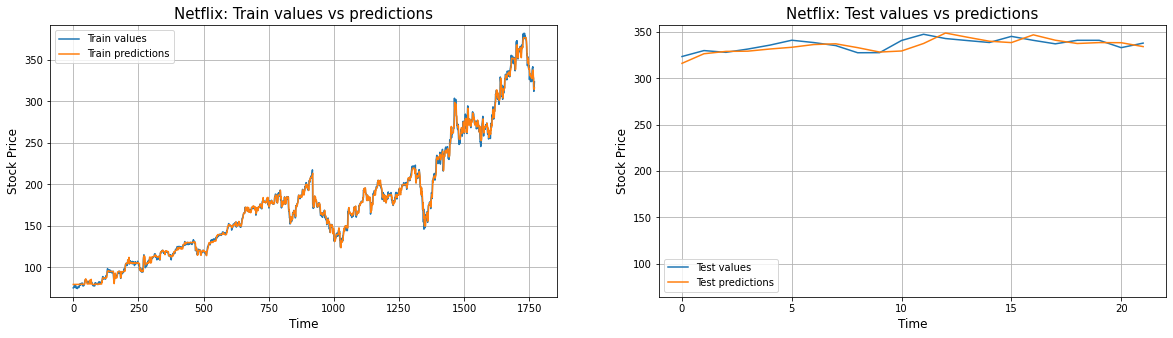

In [11]:
nflx_model = fit_rf_model(df = df, company_name = "Netflix")

## Google

Reading dataset, and adding past 10 days observations.

In [12]:
df = pd.read_csv("../Data/goog_sentiment_df.csv")
df.set_index(["Date"], inplace=True)
for n_shift in range(1, 11):
    col_name = "Adj_Close"+"_Shift_"+str(n_shift)
    df[col_name] = df["Adj_Close"].shift(n_shift)
df.dropna(inplace=True)

Model

[I 2021-12-07 22:34:49,098] A new study created in memory with name: no-name-d781a2a2-4d34-4cfe-b2f8-b5a995bf74d0
[I 2021-12-07 22:34:59,378] Trial 0 finished with value: 26159.647055924033 and parameters: {'criterion': 'poisson', 'n_estimators': 924, 'max_depth': 10, 'max_features': 0.9294170778974652, 'max_samples': 0.9646719290174749}. Best is trial 0 with value: 26159.647055924033.
[I 2021-12-07 22:35:59,105] Trial 1 finished with value: 30.175326343769346 and parameters: {'criterion': 'absolute_error', 'n_estimators': 937, 'max_depth': 7, 'max_features': 0.7956420403083143, 'max_samples': 0.6543514566961656}. Best is trial 1 with value: 30.175326343769346.
[I 2021-12-07 22:36:01,980] Trial 2 finished with value: 30.090477027602535 and parameters: {'criterion': 'squared_error', 'n_estimators': 1277, 'max_depth': 10, 'max_features': 0.5527072161395367, 'max_samples': 0.3149137939632714}. Best is trial 2 with value: 30.090477027602535.
[I 2021-12-07 22:36:04,256] Trial 3 finished wit

Training RMSE: 3.6221
Testing RMSE: 3.6221
------------------------------



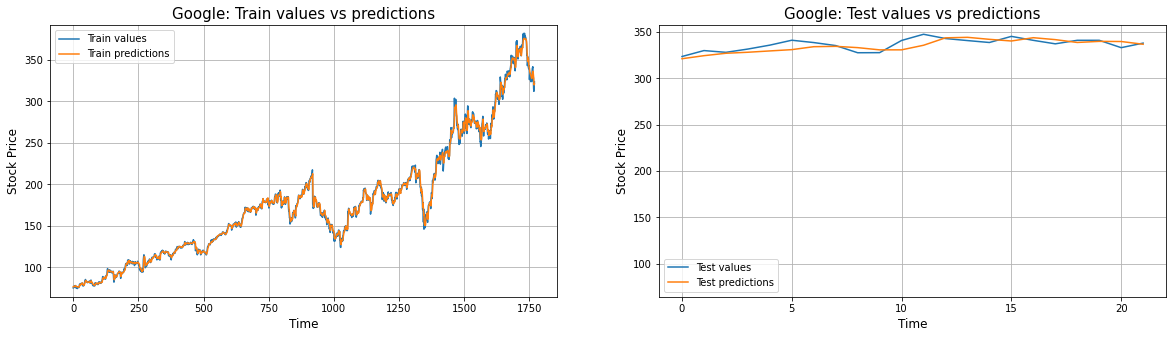

In [13]:
goog_model = fit_rf_model(df = df, company_name = "Google")

# Saving Models

In [17]:
joblib.dump(fb_model, "rf_fb.joblib")
joblib.dump(aapl_model, "rf_aapl.joblib")
joblib.dump(amzn_model, "rf_amzn.joblib")
joblib.dump(nflx_model, "rf_nflx.joblib")
joblib.dump(goog_model, "rf_goog.joblib")

['rf_goog.joblib']